# Biến dự đoán phân nhóm có thứ tự
Bs Vương Kiến Thanh

Biến dự đoán phân nhóm có thứ tự, hay Ordinal predictor, là một loại biến đặc biệt. Ví dụ:
- Thang điểm hôn mê Glasgow
- Likert scale
- Trình độ học vấn

Thông thường chúng ta hay xem chúng như là biến định lượng, để thuận tiện hơn trong việc fit vào mô hình, đồng nghĩa với việc giả định khoảng cách giữa các giá trị của biến là bằng nhau (equidistant). Nhưng điều này không hợp lý về mặt lý thuyết cũng như kiến thức chuyên môn của vấn đề.

Ordinal predictor có tính chất *monotonic*, tức là có hiệu ứng tăng(giảm) dần, và mỗi bước hiệu ứng có thể không bằng nhau. Nhiều phương pháp hồi quy khác nhau có thể dùng loại biến này, như spline, order constraint cho biến categorical,..

Hôm nay tôi xin giới thiệu một phương pháp Bayes để mô hình hoá hiệu ứng monotonic, được tác giả *Paul-Christian Burkner và Emmanuel Charpentier* giới thiệu vào năm 2020, được viết thành R package *brms*.


## Reference:
1. https://bpspsychub.onlinelibrary.wiley.com/doi/full/10.1111/bmsp.12195
2. https://fehiepsi.github.io/rethinking-numpyro/12-monsters-and-mixtures.html

In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import jax.numpy as jnp
from jax import random

az.style.use("fivethirtyeight")
#az.style.available

# Ground truth

Để nắm bắt hiệu ứng monotonic, tôi sẽ mô phỏng một tiến trình tạo dữ liệu. Hiệu ứng của x lên y là tăng dần không đều, khác nhau ở mỗi bước.  
Predictor: $x \in \{0,1,2,3\}$  
Generative process:
$$\begin{aligned}
y \sim& \text{Normal}(\mu, 1) \\
\mu =& \begin{cases}
    x=0: \text{Normal}(-4,1)\\
    x=1: \text{Normal}(-2,1)\\
    x=2: \text{Normal}(-1,1)\\
    x=3: \text{Normal}(10,1)\\
    \end{cases}\\
\end{aligned}$$

### simulate x

In [2]:
size = 100
x = dist.Categorical(
        probs=np.array([0.25, 0.25, 0.25, 0.25])
    ).sample(sample_shape=(size,), key=random.PRNGKey(0))

### simulate y

In [3]:
mu_dict = {0:-4, 1:-2, 2:-1, 3:10}

y = jnp.array([])
for enum, i in enumerate(x):
    with numpyro.handlers.seed(rng_seed=enum):
        mu = numpyro.sample('mu', dist.Normal(mu_dict[i],1))
        y_new= numpyro.sample('y', dist.Normal(mu, 1)).reshape(1)
        y = jnp.concatenate([y, y_new], axis=0)

### dataset

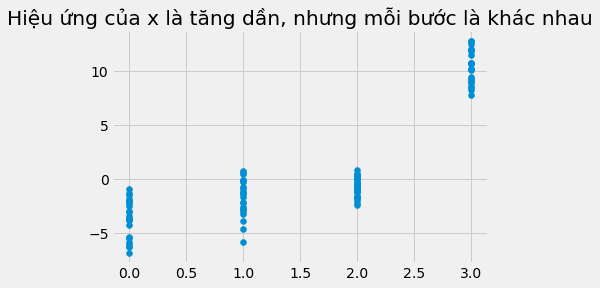

In [4]:
plt.scatter(x,y)
plt.title('Hiệu ứng của x là tăng dần, nhưng mỗi bước là khác nhau');

# The model with ordinal predictor
$$\begin{aligned}
y \sim& \text{Normal}(\mu,1) \\
\mu =& \alpha + \beta \displaystyle\sum_{k=1}^{x_i} \delta_k\\
\alpha \sim& \text{Normal}(0,1)\\
\beta \sim& \text{Normal}(0,1)\\
\delta \sim& \text{Dirichlet}([2,2,2])\\
\end{aligned}$$

Ngoài intercept $\alpha$, thì mô hình tuyến tính này có một đại lượng đáng chú ý là $\beta \displaystyle\sum_{k=1}^{x_i} \delta_k$. Trong đó, $\beta$ là hiệu ứng toàn phần của x, $\sum$ là tỉ lệ phần trăm hiệu ứng của các bước.  

Ở bước 0 (x=0), hiệu ứng của nó là hoà với intercept. Bước 1 thì hiệu ứng là $\beta\delta_1$, bước 2 thì hiệu ứng là $\beta(\delta_1 + \delta_2)$, và tiếp tục đến hết các bước. Do đó, bạn có thể để ý rằng $k$ bắt đầu từ 1 và prior cho Dirichlet chỉ có length =3, trong khi có 4 loại giá trị x.

Khi $\beta<0$, hiệu ứng này là giảm dần, ngược lại, $\beta >0$ thì tăng dần.

Một câu hỏi đặt ra là làm sao để tạo ra các $\delta$ để tổng chúng là 1, tương đương với 100% hiệu ứng. Ta cần phải nhờ đến phân phối Dirichlet.

### The Dirichlet distribution
Ta có thể xem Dirichlet như Multivariate Normal dành cho biến rời rạc. Một data point của Dirichlet là một array được phân phối theo trọng số, và có tổng là 1.

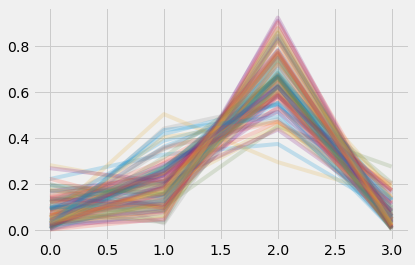

In [5]:
weights = jnp.array([1,3,10,1]) # strong prior for delta
a = dist.Dirichlet(weights).sample(key=random.PRNGKey(2), sample_shape=(100,))
plt.plot(a.T,alpha=0.2);

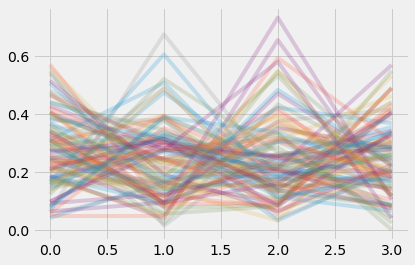

In [6]:
weights = jnp.array([2,2,2,2]) # weak prior for delta
a = dist.Dirichlet(weights).sample(key=random.PRNGKey(2), sample_shape=(100,))
plt.plot(a.T,alpha=0.2);

### Fit mô hình
Trọng số [2,2,2] là prior chứa ít thông tin cho phân phối Dirichlet. Việc fit mô hình cũng không quá phức tạp.

MCMC hoạt động rất tốt trong trường hợp này, thể hiện qua plot_trace. Các tham số cũng đã converged.

In [7]:
def model(x,y=None):
    a = numpyro.sample('a', dist.Normal(0,1))
    b = numpyro.sample('b', dist.Normal(0,1))
    d = numpyro.sample('d', dist.Dirichlet(jnp.array([2,2,2])))
    cond = jnp.arange(1,4)<=x.reshape(-1,1)
    sum_delta = jnp.sum(jnp.where(cond, d, 0), axis=-1)
    mu = a+b*sum_delta
    numpyro.sample('y', dist.Normal(mu,1), obs=y)
    
mcmc = MCMC(NUTS(model), 500,2000,4,chain_method='sequential')
mcmc.run(random.PRNGKey(2), x=x, y=y)

sample: 100%|██████████| 2500/2500 [00:04<00:00, 530.83it/s, 7 steps of size 3.58e-01. acc. prob=0.93] 


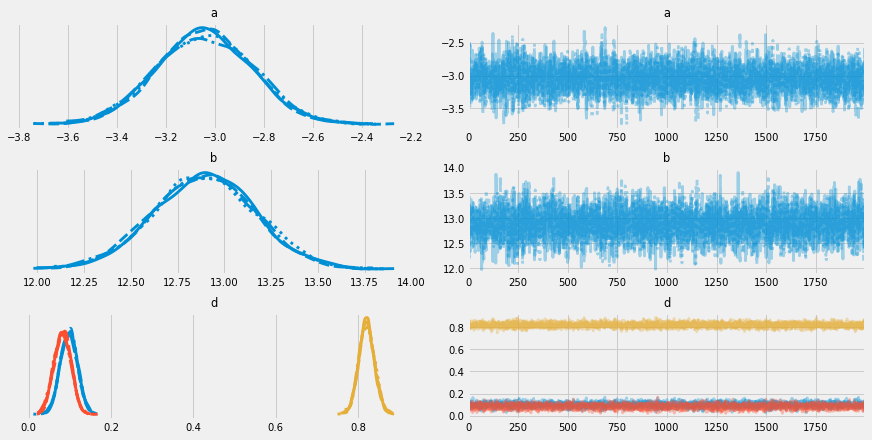

In [8]:
az.plot_trace(mcmc);

In [9]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -3.04      0.20     -3.04     -3.36     -2.72   3372.91      1.00
         b     12.89      0.27     12.89     12.44     13.34   3873.31      1.00
      d[0]      0.10      0.02      0.10      0.06      0.13   3538.21      1.00
      d[1]      0.08      0.02      0.08      0.05      0.11   4153.46      1.00
      d[2]      0.82      0.02      0.82      0.79      0.85   4387.69      1.00

Number of divergences: 0


## Visualize kết quả và so sánh với OLS

In [10]:
from sklearn.linear_model import LinearRegression as OLS
m = OLS()
m.fit(x.reshape(-1,1),y.reshape(-1,1));

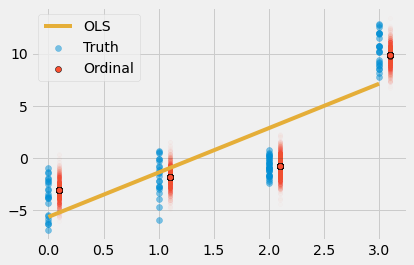

In [11]:
y_pred = Predictive(model,mcmc.get_samples())(random.PRNGKey(1),x=x)['y']
plt.scatter(x,y, alpha=0.5, label='Truth')
for i in range(50):
    plt.scatter(x+0.1,y_pred[i], c='C1',  s=20,alpha=0.01)
plt.scatter(x+0.1, y_pred.mean(0), c='C1', label='Ordinal', edgecolors='k')
arr = np.array([0,3])
plt.plot(arr, m.predict(arr.reshape(-1,1)), label='OLS', c='C2')
plt.legend();

## Kết bài:
Rõ ràng, mô hình được fit theo đúng về mặt lý thuyết và kiến thức chuyên ngành sẽ cho kết quả tốt hơn rất nhiều so với việc sử dụng mô hình truyền thống một cách mù quáng. Hi vọng bài này sẽ giúp ích cho các bạn đọc. Cám ơn.